In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import operator
import math
import os
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
import copy
import numpy as np

In [4]:
# penalty for late delivery
P=50
df_clients = pd.read_excel('2_detail_table_customers.xls')
df_depot = pd.read_excel('4_detail_table_depots.xls')
# Extraction des informations pertinentes pour les clients
ncli=30
columns_clients = ["CUSTOMER_NUMBER", "CUSTOMER_LATITUDE", "CUSTOMER_LONGITUDE",'CUSTOMER_TIME_WINDOW_TO_MIN']
data_clients = df_clients[columns_clients].rename(columns={"CUSTOMER_NUMBER": "number", "CUSTOMER_LATITUDE": "x", "CUSTOMER_LONGITUDE": "y","CUSTOMER_TIME_WINDOW_TO_MIN":"Time"})
data_clients = data_clients.head(ncli)
NUM_CLIENTS=len(data_clients)
# Extraction des informations pertinentes pour le dépôt
depot_info = df_depot[['DEPOT_CODE', 'DEPOT_LATITUDE', 'DEPOT_LONGITUDE']].drop_duplicates()
depot_info = depot_info.rename(columns={"DEPOT_CODE": "number", "DEPOT_LATITUDE": "x", "DEPOT_LONGITUDE": "y"})

client_positions = list(zip(data_clients['x'], data_clients['y']))
time_window=list(data_clients['Time'])

#class point that will help us calculate the distance between clients
class Point:
    def __init__(self, x, y,client_id):
        self.x = x
        self.y = y
        self.client_id = client_id
    def distance(self, p):
        xDis = self.x - p.x
        yDis = self.y - p.y
        distance = math.sqrt(xDis ** 2 + yDis ** 2)
        return distance
    
    def __repr__(self):
        return f"({self.x},{self.y})"
pointsL=[]
for i in range(len(client_positions)):
    pointsL.append(Point((client_positions[i][0]),(client_positions[i][1]),i))

#function to separate a list of client coordinates into sublists each corresponding to a vehicle route
def split_list(input_list, n):
    sublist_size = len(input_list) // n
    remainder = len(input_list) % n
    sublists = []
    index = 0
    for i in range(n):
        sublist = input_list[index:index + sublist_size]
        if remainder > 0:
            sublist.append(input_list[index + sublist_size])
            remainder -= 1
            index += sublist_size + 1
        else:
            index += sublist_size
        sublists.append(sublist)
    return sublists
n=3
def createIt(pointsList):
    return random.sample(pointsList, len(pointsList))

i1=split_list(createIt(pointsL),n)
i2=split_list(createIt(pointsL),n)

#initialize a population for genetic algorithm
def initialPopulation(popSize, pointsL):
    population = []

    for i in range(popSize):
        population.append(split_list(createIt(pointsL),n))
    return population

#myPop1=initialPopulation(10, pointsL)
myPop2=initialPopulation(7, pointsL)


pointDepot=Point(depot_info.iloc[0]['x'], depot_info.iloc[0]['y'],0)


# a class to determine the objective function 
class Fitness:
    def __init__(self, it):
        self.it = it
        self.distance = 0
        self.fitness= 0.0
    
    def itDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(len(self.it)):
                if i==0 :
                    fromPoint = pointDepot
                    toPoint=self.it[i]
                    pathDistance+=fromPoint.distance(toPoint)
                    
                fromPoint = self.it[i]
                toPoint = None
                if i + 1 < len(self.it):
                    toPoint = self.it[i + 1]
                else:
                    toPoint=pointDepot
                    pathDistance+=fromPoint.distance(toPoint)
                    toPoint = self.it[0]
                pathDistance += fromPoint.distance(toPoint)
                if(pathDistance*900>time_window[toPoint.client_id]):
                    pathDistance+=P
            self.distance = pathDistance
        return self.distance
    
    def itFitness(self):
        if self.fitness == 0:
            if float(self.itDistance())==0:
                print(self.it)
            self.fitness = 1 / float(self.itDistance())
        return self.fitness
    

def rankIts(population):
    fitnessResults = {}
    for i in range(len(population)):
        somme=0
        for j in range(len(population[i])):
            somme+=1/Fitness(population[i][j]).itFitness()
            #fitnessResults[i].append((j, Fitness(population[i][j]).itFitness()))
            
        fitnessResults[i] = 1/somme
    ranked_results = sorted(fitnessResults.items(), key=operator.itemgetter(1), reverse=True)
    #print(fitnessResults)
    return ranked_results

popRanked=rankIts(myPop2)
selectionResults = []
df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
df['cum_sum'] = df.Fitness.cumsum()
df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
selectionResults = []
for i in range(4):
    selectionResults.append(popRanked[i][0])
for i in range(len(popRanked) - 4):
    pick = random.randint(0,100)
    for i in range(len(popRanked)):
        if pick <= df.iat[i,3]:
            selectionResults.append(popRanked[i][0])
            break
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults
selectionResults= selection(popRanked, 5)
def croisementOr(parent1, parent2):
    parent1copy=[]
    parent2copy=[]
    for i in range(n):
        parent1copy+=parent1[i]
        parent2copy+=parent2[i]
    child = []
    childP1 = []
    childP2 = []
    
    #geneA = int(random.random() * len(parent1))
    #geneB = int(random.random() * len(parent1))
    geneA = random.randint(0,len(parent1copy))
    geneB = random.randint(0,len(parent1copy))
    #print(geneA)
    #print(geneB)
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1copy[i])
        
    childP2 = [item for item in parent2copy if item not in childP1]

    child = childP1 + childP2
    return split_list(child,n)
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool
# matingpool : liste des chromosomes selectionnés pour le croisement
def nouvelleGeneration(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize

    #liste aléatoire puisque dans ma mating pool j'ai les élites en premier
    pool = random.sample(matingpool, len(matingpool))

    #je récupére les élite qu'il ne faut pas toucher
    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    #ensuite le reste est le résultat du croisement
    for i in range(0, length):
        child = croisementOr(pool[i], pool[len(matingpool)-i-1]) #le 1er avec le dernier, le 2ème avec l'avant dernier...
        children.append(child)
    return children
def mutation(individual, mutationRate):
    individualcopy=[]
    for i in range(n):
        individualcopy+=individual[i]
    for swapped in range(len(individualcopy)):
        if(random.random() < mutationRate):
            #swapWith = int(random.random() * len(individual))
            swapWith = random.randint(0,len(individualcopy)-1)
            point1 = individualcopy[swapped]
            point2 = individualcopy[swapWith]
            
            individualcopy[swapped] = point2
            individualcopy[swapWith] = point1
    return split_list(individualcopy,n)

def mutationPopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(len(population)):
        mutatedInd = mutation(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankIts(currentGen)
    #print(popRanked)
    selectionResults = selection(popRanked, eliteSize) #selection des indices pour le croisement
    matingpool = matingPool(currentGen, selectionResults) # la liste selectionnée
    children = nouvelleGeneration(matingpool, eliteSize) #croisement
    nextGeneration = mutationPopulation(children, mutationRate) #mutation
    #nextGeneration = Q_algorithme_search(children[0])[0]
    return nextGeneration

## GA MAS

In [5]:

n=2
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankIts(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = nouvelleGeneration(matingpool, eliteSize)
    nextGeneration = mutationPopulation(children, mutationRate)
    return nextGeneration
    
class OptGenAgent(Agent):
    def __init__(self, unique_id, model, collaboratif=False):
        super().__init__(unique_id, model)        
        self.pop = initialPopulation(self.model.popSize, self.model.population)
        self.best=1 / rankIts(self.pop)[0][1]
        self.collaboratif=collaboratif
        self.bestroute = self.pop[rankIts(self.pop)[0][0]]
    '''
    si je suis collaboratif, j'entre en contact avec les autres
    je vérifie s'il y a mieux que moi, dans ce cas, je recupere le meilleur dans ma population
    '''
    def contact(self):
        min=self.best
        
        for a in self.model.schedule.agents:
            if a.best<min:
                min=a.best
                best_agent=a
                
        #si ce n'est pas moi qui détient la meilleure valeur, je la prend
        #plusieurs techniques : soit juste je remplace mon meillur, on je décale de manière à supprimer mon pire
        #je commence par une solution simple, je remplace juste mon meilleur gene
        #je trouve mon meilleur gene
        
        mon_meilleure_fitness=0
        for i in range(len(self.pop)):
            somme=0
            for j in range(len(self.pop[i])):
                somme+=Fitness(self.pop[i][j]).itFitness()
            if somme>mon_meilleure_fitness:
                mon_meilleure_fitness=somme
                mon_meilleur_gene=i
        
        if min!=self.best:
            if type(best_agent).__name__=="OptGenAgent":
                son_meilleure_fitness=0
                for i in range(len(best_agent.pop)):
                    somme=0
                    for j in range(len(best_agent.pop[i])):
                        somme+=Fitness(best_agent.pop[i][j]).itFitness()
                    if somme>son_meilleure_fitness:
                        son_meilleure_fitness=somme
                        son_meilleur_gene=i
                
                #j'échange mon meilleur avec l'autre meilleur
                self.pop[mon_meilleur_gene]=best_agent.pop[son_meilleur_gene]
                self.best=1 / rankIts(self.pop)[0][1]
            else:
                self.pop[mon_meilleur_gene]=best_agent.bestroute[:]

    #passser d'une génération à une autre
    def step(self):
        self.pop = nextGeneration(self.pop, self.model.eliteSize, self.model.mutationRate)
        self.best=1 / rankIts(self.pop)[0][1]
        self.bestroute = self.pop[rankIts(self.pop)[0][0]]
        if self.collaboratif==True:
            self.contact()



    

class OptimisationCollaborativeModel(Model):

    def __init__(self, population, N=6, popSize=100, eliteSize=50, mutationRate=0.00005):
        super().__init__()
        self.population = population
        self.num_agents = N
        self.popSize = popSize
        self.eliteSize = eliteSize
        self.mutationRate = mutationRate
        
        #The scheduler
        self.schedule = SimultaneousActivation(self)
        
        # Create agents
        for i in range(int(self.num_agents/2)):
            a = OptGenAgent(i, self, True)
            self.schedule.add(a)
        """   
        for i in range(int(self.num_agents/2),self.num_agents):
            a = OptTabuAgent(i, self, True)
            self.schedule.add(a)
        """ 
        self.datacollector = DataCollector(
            #model_reporters={"TheGlobalBest": compute_global_best},
            agent_reporters={"Best Distance": lambda a:a.best, "Best route":lambda a:a.bestroute})


    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        

generations=200

cityList = pointsL

model = OptimisationCollaborativeModel(cityList)

for i in range(generations):
    print(f"Génération n{i+1}")
    model.step()  
    

agent_state = model.datacollector.get_agent_vars_dataframe()
print(agent_state)


C:\Users\omeganet\ansel\lib\site-packages\mesa\time.py:82: FutureWarning: The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919
  self._agents: AgentSet = AgentSet(agents, model)


Génération n1
Génération n2
Génération n3
Génération n4
Génération n5
Génération n6
Génération n7
Génération n8
Génération n9
Génération n10
Génération n11
Génération n12
Génération n13
Génération n14
Génération n15
Génération n16
Génération n17
Génération n18
Génération n19
Génération n20
Génération n21
Génération n22
Génération n23
Génération n24
Génération n25
Génération n26
Génération n27
Génération n28
Génération n29
Génération n30
Génération n31
Génération n32
Génération n33
Génération n34
Génération n35
Génération n36
Génération n37
Génération n38
Génération n39
Génération n40
Génération n41
Génération n42
Génération n43
Génération n44
Génération n45
Génération n46
Génération n47
Génération n48
Génération n49
Génération n50
Génération n51
Génération n52
Génération n53
Génération n54
Génération n55
Génération n56
Génération n57
Génération n58
Génération n59
Génération n60
Génération n61
Génération n62
Génération n63
Génération n64
Génération n65
Génération n66
Génération n67
Géné

        Best Distance                            \
AgentID             0            1            2   
Step                                              
0         1160.604212  1061.547125  1114.224685   
1         1061.547125  1061.547125  1061.547125   
2         1061.547125  1061.547125  1061.547125   
3          960.181095   960.181095   960.181095   
4          960.181095   960.181095   960.181095   
...               ...          ...          ...   
195        203.897976   203.897976   203.897976   
196        203.897976   203.897976   203.897976   
197        203.897976   203.897976   203.897976   
198        203.897976   203.897976   203.897976   
199        203.897976   203.897976   203.897976   

                                                Best route  \
AgentID                                                  0   
Step                                                         
0        [[(43.35266,17.80444), (43.396088,17.871369), ...   
1        [[(43.35266,17.80444), (43.0

<AxesSubplot:title={'center':'3 collaborative GA agents'}, xlabel='Step'>

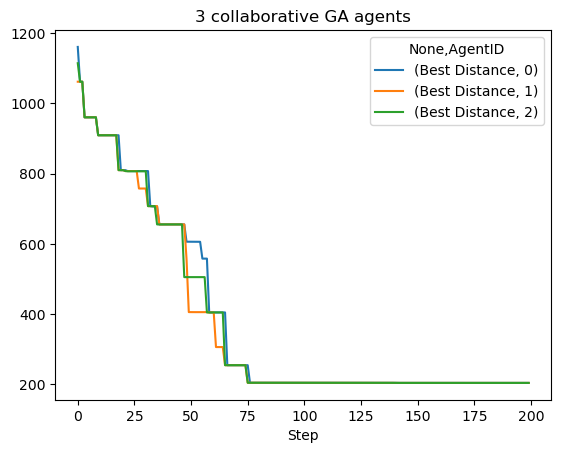

In [6]:
res=agent_state.unstack()
print(res)
res.plot(title='3 collaborative GA agents')

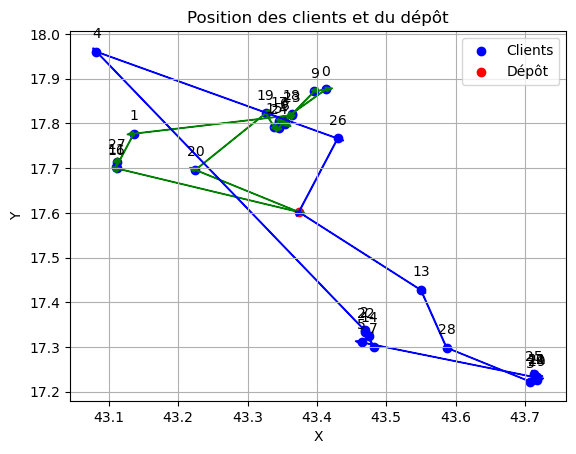

In [7]:
res1=res['Best Distance']
res2=res['Best route']
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
DEPOT = (depot_info.iloc[0]['x'], depot_info.iloc[0]['y'])
plt.scatter(*zip(*client_positions), color='blue', label='Clients')
plt.scatter(*DEPOT, color='red', label='Dépôt')
for i, (x, y) in enumerate(client_positions):
    plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0,10), ha='center')


for i in range(n):
        current_location = DEPOT

        for client_position in res2[res1.min().idxmin()][res1.idxmin()[res1.min().idxmin()]][i]:
                client_position = [client_position.x,client_position.y]
                plt.arrow(current_location[0], current_location[1], client_position[0] - current_location[0],
                        client_position[1] - current_location[1], head_width=0.01, head_length=0.01, fc=color[i], ec=color[i])
                current_location = client_position
        plt.arrow(current_location[0], current_location[1], DEPOT[0] - current_location[0],
                DEPOT[1] - current_location[1], head_width=0.01, head_length=0.01, fc=color[i], ec=color[i])


plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Position des clients et du dépôt')
plt.grid(True)
plt.show()

## Tabu MAS

In [8]:
# Extraction des informations pertinentes pour les clients
ncli=30
columns_clients = ["CUSTOMER_NUMBER", "CUSTOMER_LATITUDE", "CUSTOMER_LONGITUDE",'CUSTOMER_TIME_WINDOW_TO_MIN']
data_clients = df_clients[columns_clients].rename(columns={"CUSTOMER_NUMBER": "number", "CUSTOMER_LATITUDE": "x", "CUSTOMER_LONGITUDE": "y","CUSTOMER_TIME_WINDOW_TO_MIN":"Time"})
data_clients = data_clients.head(ncli)
NUM_CLIENTS=len(data_clients)
# Extraction des informations pertinentes pour le dépôt
depot_info = df_depot[['DEPOT_CODE', 'DEPOT_LATITUDE', 'DEPOT_LONGITUDE']].drop_duplicates()
depot_info = depot_info.rename(columns={"DEPOT_CODE": "number", "DEPOT_LATITUDE": "x", "DEPOT_LONGITUDE": "y"})
n=2
# Ajout du dépôt aux données clients
"""data_clients.loc[len(data_clients)] = depot_info.iloc[0]
data_clients[['x', 'y']] = data_clients[['x', 'y']]
# Constantes pour les positions des clients et du dépôt

DEPOT = (data_clients.iloc[-1]['x'], data_clients.iloc[-1]['y'])"""
client_positions = list(zip(data_clients['x'], data_clients['y']))
time_window=list(data_clients['Time'])

import math
class Point:
    def __init__(self, x, y,client_id):
        self.x = x
        self.y = y
        self.client_id = client_id
    def distance(self, p):
        xDis = self.x - p.x
        yDis = self.y - p.y
        distance = math.sqrt(xDis ** 2 + yDis ** 2)
        return distance
    
    def __repr__(self):
        return f"({self.x},{self.y})"
pointsL=[]
for i in range(len(client_positions)):
    pointsL.append(Point((client_positions[i][0]),(client_positions[i][1]),i))
    
def split_list(input_list, n):
    sublist_size = len(input_list) // n
    remainder = len(input_list) % n
    sublists = []
    index = 0
    for i in range(n):
        sublist = input_list[index:index + sublist_size]
        if remainder > 0:
            sublist.append(input_list[index + sublist_size])
            remainder -= 1
            index += sublist_size + 1
        else:
            index += sublist_size
        sublists.append(sublist)
    return sublists
def createIt(pointsList):
    return random.sample(pointsList, len(pointsList))

i1=split_list(createIt(pointsL),n)
i2=split_list(createIt(pointsL),n)
def initialPopulation(popSize, pointsL):
    population = []

    for i in range(popSize):
        population.append(split_list(createIt(pointsL),n))
    return population

#myPop1=initialPopulation(10, pointsL)
myPop2=initialPopulation(7, pointsL)


pointDepot=Point(depot_info.iloc[0]['x'], depot_info.iloc[0]['y'],0)

class Fitness:
    def __init__(self, it):
        self.it = it
        self.distance = 0
        self.fitness= 0.0
    
    def itDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(len(self.it)):
                if i==0 :
                    fromPoint = pointDepot
                    toPoint=self.it[i]
                    pathDistance+=fromPoint.distance(toPoint)
                    
                fromPoint = self.it[i]
                toPoint = None
                if i + 1 < len(self.it):
                    toPoint = self.it[i + 1]
                else:
                    toPoint=pointDepot
                    pathDistance+=fromPoint.distance(toPoint)
                    toPoint = self.it[0]
                pathDistance += fromPoint.distance(toPoint)
                #if(pathDistance*900>time_window[toPoint.client_id]):
                #    pathDistance+=P
            self.distance = pathDistance
        return self.distance
    
    def itFitness(self):
        if self.fitness == 0:
            if float(self.itDistance())==0:
                print(self.it)
            self.fitness = 1 / float(self.itDistance())
        return self.fitness
    
import operator
def rankIts(population):
    fitnessResults = {}
    for i in range(len(population)):
        somme=0
        for j in range(len(population[i])):
            somme+=1/Fitness(population[i][j]).itFitness()
            #fitnessResults[i].append((j, Fitness(population[i][j]).itFitness()))
            
        fitnessResults[i] = 1/somme
    ranked_results = sorted(fitnessResults.items(), key=operator.itemgetter(1), reverse=True)
    #print(fitnessResults)
    return ranked_results

popRanked=rankIts(myPop2)
selectionResults = []
df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
df['cum_sum'] = df.Fitness.cumsum()
df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
selectionResults = []
for i in range(4):
    selectionResults.append(popRanked[i][0])
for i in range(len(popRanked) - 4):
    pick = random.randint(0,100)
    for i in range(len(popRanked)):
        if pick <= df.iat[i,3]:
            selectionResults.append(popRanked[i][0])
            break

def fonction_objectif( solution):
    somme=0
    for j in range(len(solution)):
        somme+=1/Fitness(solution[j]).itFitness()
        
            #fitnessResults[i].append((j, Fitness(population[i][j]).itFitness()))
    return 1/somme

def initialiser_solution(pointsList):
    nb_veh = random.randint(1,4)
    return split_list(random.sample(pointsList, len(pointsList)),2)

def generer_voisins(solution,n_voisins=50):
    voisins = []
    n=len(solution)
    voisins=[]    
    for i in range(n_voisins):
        L=[]
        l = random.randint(0,len(solution)-1)
        voisin0=copy.deepcopy(solution[l])
        i1=np.random.randint(0,len(voisin0)-1)
        # Déplacer le client vers une autre position dans la route
        client = voisin0.pop(i1)
        j = random.randint(0, len(voisin0)-1)  # Sélectionner une nouvelle position au hasard
        voisin0.insert(j, client)
        L.extend(solution[:l])
        L.append(voisin0)
        if( l<len(solution)-1):
            L.extend(solution[l+1:])
        voisins.append(L)
        
        if(len(solution)>2):
            l1,l2=sorted(random.sample(range(0,len(solution)),2))
            voisin0=copy.deepcopy(solution[l1])
            voisin1=copy.deepcopy(solution[l2])
            i1=random.randint(0,min(len(solution[l1]),len(solution[l2]))-1)
            voisin0[i1],voisin1[i1]=voisin1[i1],voisin0[i1]
            L=copy.deepcopy(solution)
            L.pop(l1)
            L.insert(l1,voisin0)
            L.pop(l2)
            L.insert(l2,voisin1)
            voisins.append(L)
        elif(len(solution)==2):
            voisin0=copy.deepcopy(solution[0])
            voisin1=copy.deepcopy(solution[1])
            i1=random.randint(0,min(len(solution[0]),len(solution[1]))-1)
            voisin0[i1],voisin1[i1]=voisin1[i1],voisin0[i1]
            L=copy.deepcopy(solution)
            L.pop(0)
            L.insert(0,voisin0)
            L.pop(1)
            L.insert(1,voisin1)
            voisins.append(L)
    return voisins

    


class OptTabuAgent(Agent):
    def __init__(self, unique_id, model, collaboratif=False):
        super().__init__(unique_id, model)        
        self.sol = initialiser_solution(pointsL)
        self.bestA=fonction_objectif(self.sol)
        self.collaboratif=collaboratif
        self.bestroute= self.sol[:]
        self.best_iter=0
        self.iter=0
        self.limit=40
        self.compt=100
        self.history=[self.bestA]
        self.T=[self.sol]
        self.taille_max_T=5
        self.best=1/self.bestA

    """def contact(self):
        max=self.best
        
        for a in self.model.schedule.agents:
            if a.best>max:
                max=a.best
                best_agent=a
                self.bestroute=a.sol
                self.bestA=min"""

    def contact(self):
        min=self.best
        
        for a in self.model.schedule.agents:
            if a.best<min:
                min=a.best
                best_agent=a
                
        #si ce n'est pas moi qui détient la meilleure valeur, je la prend
        #plusieurs techniques : soit juste je remplace mon meillur, on je décale de manière à supprimer mon pire
        #je commence par une solution simple, je remplace juste mon meilleur gene
        #je trouve mon meilleur gene
        
        if min!=self.best:
            if type(best_agent).__name__=="OptGenAgent":
                son_meilleure_fitness=0
                for i in range(len(best_agent.pop)):
                    somme=0
                    for j in range(len(best_agent.pop[i])):
                        somme+=Fitness(best_agent.pop[i][j]).itFitness()
                    if somme>son_meilleure_fitness:
                        son_meilleure_fitness=somme
                        son_meilleur_gene=i
                
                #j'échange mon meilleur avec l'autre meilleur
                self.bestroute=best_agent.pop[son_meilleur_gene]
                self.best=best_agent.best
            else:
                self.bestroute=a.bestroute
                #self.sol=copy.deepcopy(a.bestroute)
                self.best=min

    def step(self):
        self.iter+=1
        if(self.iter-self.best_iter>=100) :    
            if self.compt==100:
                #print('yes')
                self.solution=initialiser_solution(pointsL)
            self.compt-=1
        
        if self.compt ==0:
            self.compt =100
            
        
        voisins = generer_voisins(self.sol)
        meilleure_voisin = max(voisins,key= lambda x:fonction_objectif(x))        
        
        while meilleure_voisin in self.T:
            voisins.remove(meilleure_voisin)
            meilleure_voisin = max(voisins,key= lambda x:fonction_objectif(x))
        
        # Mettre à jour la meilleure solution trouvée
        if (fonction_objectif(meilleure_voisin) > self.bestA) and (meilleure_voisin not in self.T):
            self.bestroute = meilleure_voisin[:]
            self.bestA=fonction_objectif(meilleure_voisin)
        
        self.T.append(meilleure_voisin) 
        if len(self.T) > self.taille_max_T:
            self.T.pop(0)  # Supprimer le plus ancien élément de T
        # Mettre à jour la fonction d'aspiration
        A = fonction_objectif(self.bestroute)
        # Mettre à jour la solution courante
        self.sol = meilleure_voisin[:]
        self.history.append(A)
        
        self.best= 1/self.bestA

        if self.collaboratif==True:
            self.contact()    
            
class OptimisationCollaborativeModel(Model):

    def __init__(self, population, N=6, popSize=100, eliteSize=50, mutationRate=0.00005):
        super().__init__()
        self.population = population
        self.num_agents = N
        self.popSize = popSize
        self.eliteSize = eliteSize
        self.mutationRate = mutationRate
        
        #The scheduler
        self.schedule = SimultaneousActivation(self)
        
        # Create agents
        for i in range(int(self.num_agents)):
            a = OptTabuAgent(i, self, True)
            self.schedule.add(a)
        """for i in range(int(self.num_agents/2),self.num_agents):
            a = OptTabuAgent(i, self, True)
            self.schedule.add(a)
        """ """  
        for i in range(int(self.num_agents/2),self.num_agents):
            a = OptGenAgent(i, self, True)
            self.schedule.add(a)
        """ 
        self.datacollector = DataCollector(
            #model_reporters={"TheGlobalBest": compute_global_best},
            agent_reporters={"Best Distance": lambda a:a.best, "Best route":lambda a:a.bestroute})


    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
generations=200

cityList = pointsL

model = OptimisationCollaborativeModel(cityList)

for i in range(generations):
    #print(f"Génération n{i+1}")
    model.step()  
    

agent_state = model.datacollector.get_agent_vars_dataframe()
res=agent_state.unstack()
res1=res['Best Distance']
res2=res['Best route']

s=res1.min().min()

<AxesSubplot:title={'center':'Tabu + MAS 6 collab agents convergence curve'}, xlabel='Step'>

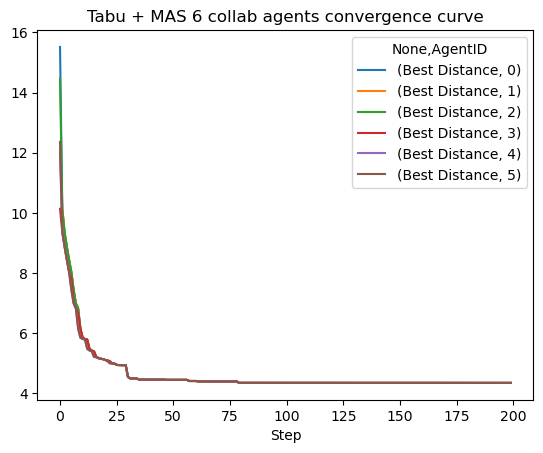

In [9]:
res=agent_state.unstack()
res.plot(title='Tabu + MAS 6 collab agents convergence curve')

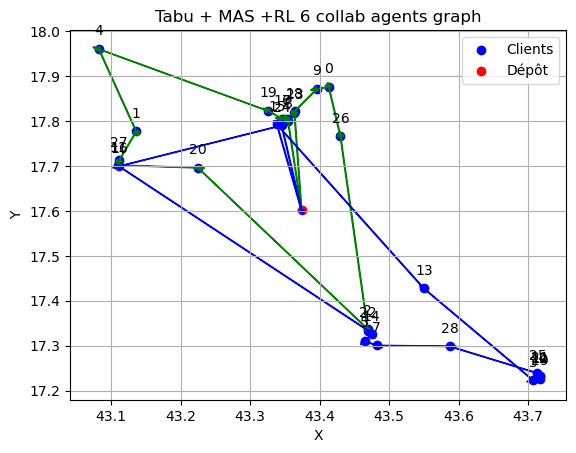

In [10]:
res1=res['Best Distance']
res2=res['Best route']
prop_cycle = plt.rcParams['axes.prop_cycle']
color = prop_cycle.by_key()['color']
DEPOT = (depot_info.iloc[0]['x'], depot_info.iloc[0]['y'])
plt.scatter(*zip(*client_positions), color='blue', label='Clients')
plt.scatter(*DEPOT, color='red', label='Dépôt')
for i, (x, y) in enumerate(client_positions):
    plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0,10), ha='center')


for i in range(n):
        current_location = DEPOT

        for client_position in res2[res1.min().idxmin()][res1.idxmin()[res1.min().idxmin()]][i]:
                client_position = [client_position.x,client_position.y]
                plt.arrow(current_location[0], current_location[1], client_position[0] - current_location[0],
                        client_position[1] - current_location[1], head_width=0.01, head_length=0.01, fc=color[i], ec=color[i])
                current_location = client_position
        plt.arrow(current_location[0], current_location[1], DEPOT[0] - current_location[0],
                DEPOT[1] - current_location[1], head_width=0.01, head_length=0.01, fc=color[i], ec=color[i])


plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Tabu + MAS +RL 6 collab agents graph')
plt.grid(True)
plt.show()